In [1]:
'''
To run hit Kernel > restart & run all.

Scroll to the bottom to select the gft and fasta files with the drop down.

Resulting graphs and analysis will be output below
'''

'\nTo run hit Kernel > restart & run all.\n\nScroll to the bottom to select the gft and fasta files with the drop down.\n\nResulting graphs and analysis will be output below\n'

In [2]:
''' If you have issues with unfound packages, uncomment the pip install lines below'''
# ! pip install ipywidgets
# ! jupyter nbextension enable --py widgetsnbextension
# ! pip install matplotlib
# ! pip install pandas
''' If you have issues with unfound packages, uncomment the pip install lines above'''

' If you have issues with unfound packages, uncomment the pip install lines above'

In [3]:
from ipywidgets import *
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
from ipywidgets import HBox, Label

# %matplotlib inline

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
class FileType(Enum):
    UNSUPPORTED = 0
    FASTA = 1
    GFT = 2
    
# TODO use this object to keep track of state information?
class State:
    fasta_file = None
    gft_file = None
    exon_start = None
    display_objects = {}
    
    def state_complete():
        return fasta_file is None
    
summary = {}

In [16]:
def graph_data(series):
    plt.plot(series)
    plt.ylabel('Y label')
    plt.xlabel('X label')
    plt.title('Title')
    plt.show()
    return plt

def read_gft(filename):
    gft = pd.read_csv(filename, sep=r'[;\t]', 
                     header=None, 
                     names=["seqname", "source", "feature", "coordinate1", "coordinate2", "score", "orientation", "frame", 
                            "gene_id", "transcript_id", "drop_me"],
                     engine='python')
    gft = gft.drop("drop_me", axis=1)
    return gft

def get_avg_gene_span(gft):
    spans = []
    for gid in gft.gene_id.unique():
        exon_coordinate_list = (gft[ gft.gene_id == gid].coordinate1).append(gft[ gft.gene_id == gid].coordinate2)
        gene_span = exon_coordinate_list.max() - exon_coordinate_list.min() + 1
        spans.append(gene_span)
    return pd.Series(spans).mean()

def get_avg_intergenic_space(gft):
    # intergenic space is min cordinate 1 of gene 2      max cordinate 2 of gene 1
    spacing = pd.DataFrame()
    spacing["left"] = gft.groupby("gene_id").coordinate1.min()
    spacing["right"] = gft.groupby("gene_id").coordinate1.max()
    diff = []
    for r in range(0, len(spacing) - 1):
        diff.append(spacing.iloc[r + 1].right - spacing.iloc[r].left)
    return pd.Series(diff).mean()

def get_avg_length(gft, condition):
    gft = gft[condition]
    spacing = pd.DataFrame()
    spacing["left"] = gft.coordinate1
    spacing["right"] = gft.coordinate2
    diff = []
    for r in range(0, len(spacing) - 1):
            diff.append(spacing.iloc[r].left - spacing.iloc[r + 1].right + 1)
    return pd.Series(diff).mean()

def find_200_before_gene(gft):
    starts = {}
    mi = gft.groupby("gene_id").min()
    ma = gft.groupby("gene_id").max()

    for n in ma[ma.orientation == '-'].index:
        starts[str(n)] = (ma.loc[n].coordinate2, ma.loc[n].coordinate2 + 200)

    for n in mi[mi.orientation == '+'].index:
        starts[str(n)] = (mi.loc[n].coordinate1 - 200, mi.loc[n].coordinate1)
    return starts
    

def process_gft(gft):
    global summary
    summary["Number of Genes"] = gft.gene_id.nunique()
    summary["Gene Density"] = gft.gene_id.nunique() / gft.gene_id.count()
    summary["Average Gene Span"] = get_avg_gene_span(gft[gft.feature != "stop_codon"])
    summary["Average Intergenic Spaces"] = get_avg_intergenic_space(gft) 
    
    summary["Average Intron Length"] = get_avg_length(gft, gft.feature == "exon")
    
    summary["Number of Exons"] = gft[gft.feature == "exon"].seqname.count()
    summary["Number of Introns"] = summary["Number of Exons"] - 1
    summary["Average Exon Length"] = (gft[gft.feature != "stop_codon"].coordinate2 - gft[gft.feature != "stop_codon"].coordinate1 + 1).mean()
    
    summary["Average GC Content"] = "Use information from the fasta file!"
    
    summary["Starts"] = find_200_before_gene(gft)
    return summary
    
def read_lab1(filename):
    seq = ""
    with open(filename) as file:
        line1 = file.readline()
        seq = file.read().replace('\n', "").replace('\t', "")
    d = {'A': [], 'C': [], 'G': [], 'T': [], 'N': []}
    for s in seq:
        d[s].append(1)
        for k in d.keys():
            if k is not s:
                d[k].append(0)
    df = pd.DataFrame(d)
    return df
    
def analyze_lab1(df):
    total_gc = df.C.mean() + df.G.mean()
    global summary 
    summary["Average GC Content"] = total_gc
    summary["Total Unknown"] = df.N.mean()
    
    s = int(df.shape[0])
    window_size = int(s / 20)
    plt.plot(total_gc)
    off = int(s/float(66.6))

    # TODO make this better. 
    if off == 0:
        plt.plot(get_averages(df, s, window_size, offset=0)[0])
    else:
        for o in range(0, window_size, off):
            plt.plot(get_averages(df, s, window_size, offset=o)[0])

    plt.ylabel('Percentage')
    plt.xlabel('Window Number')
    
    locs = list(summary["Starts"].values())[0]
    print(locs)
    plt.title('GC Percentage from %s to %s' %(locs[0], locs[1]))
    plt.show()
    return plt

def get_averages(df, s, window_size, offset=0, print_me=False):
    rolling_avg = []
    window = []
    for i in range(offset, s, window_size):
        gc = df.iloc[i : i + window_size].G.mean() + df.iloc[i : i + window_size].C.mean()
        if print_me:
            print("window: ", i, i + window_size, "\t the gc content is: ", gc, "unknown: ", df.iloc[i : i + window_size].N.mean())
        rolling_avg.append(gc)
        window.append((i, i+window_size))
    return rolling_avg, window
    

def handle_gft(fname):
    filename = "data/" + fname
    file_type = FileType.GFT
    with open(filename) as file:
        line1 = file.readline()
        # TODO some type check for is GFT or GFF file!
        if line1[0] is '>':
            raise UserWarning("That file type is unsupported. Exiting.")
            sys.exit(-1)
    df = read_gft(filename)
    summary = process_gft(df)
    return summary

def handle_fasta(fname):
    filename = "data/" + fname
    file_type = FileType.FASTA
    with open(filename) as file:
        line1 = file.readline()
        # TODO additional type check for is GFT or GFF file!
        if line1[0] is not '>':
            raise UserWarning("That file type is unsupported. Exiting.")
            sys.exit(-1)

    df = read_lab1(filename)
    # loop on analysis for each gene
    global summary        
    genes_start = summary["Starts"]
    
    for gene, locations in genes_start.items():
        upstream_region = df.loc[locations[0] : locations[1]]
        analyze_lab1(upstream_region)
        x = upstream_region.stack()
        up_list = pd.Series(pd.Categorical(x[x!=0].index.get_level_values(1))).tolist()
        print("Motif locations for", gene)
        motif_location = get_mos("".join(up_list))
    print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")

    print("\n".join("{}: {}".format(k, v) for k, v in summary.items()))
    #     return plt_instance
    
    

In [17]:
def frequentWords( s, k ):
    counts = {}
    for i in range(0,len(s)-k+1):
        if "N" in s[i:i+k]:
            continue
        if s[i:i+k] not in counts:
            counts[s[i:i+k]] = 0
        counts[s[i:i+k]] += 1
    m = max(counts.values())
    
    top_counts = list(counts.values())
    top_counts.sort()
    top_counts = top_counts[-3:]
    
    out = []
    for kmer in counts:
        if k > 5 and (counts[kmer] in top_counts) and (counts[kmer] >= 2):
            out.append(kmer)
        elif counts[kmer] in top_counts and (counts[kmer] > 2):
            out.append(kmer)
    return out

In [18]:
def get_motifs_and_locations(f, seq):
    # please dont judge me chris
    motif_location = {}
    k = len(f[0])
    for i in range(0,len(seq) - k + 1):
        window = seq[i : i + k]
        if window in f:
            if window not in motif_location:
                motif_location[window] = []
            motif_location[window].append(i)
    print("\n".join("{}: {}".format(k, v) for k, v in motif_location.items()))

In [19]:
def get_mos(my_sequence):
    for i in range(3, 11):
        f = frequentWords(my_sequence, i)
        if f:
            get_motifs_and_locations(f, my_sequence)
        else:
            break

Dropdown(description='GFT:', options=('gft1.txt', 'DNA.txt', 'customgft.txt', 'Imagine9GFF.txt', 'Contig4_GFT.…

Dropdown(description='FASTA:', options=('gft1.txt', 'DNA.txt', 'customgft.txt', 'Imagine9GFF.txt', 'Contig4_GF…

(1047, 1247)


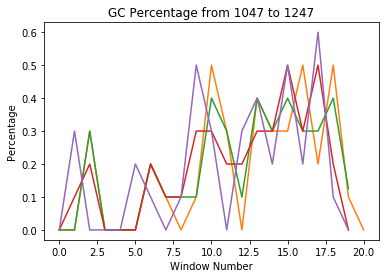

Motif locations for gene_id "Imagine9"
ATT: [61, 80, 85, 143, 148, 170, 197]
AGA: [76, 104, 113, 130, 162, 168, 180]
TTT: [81, 82, 86, 87, 109, 110, 171, 172, 189, 190, 191, 198]
AATT: [79, 142, 196]
ATTT: [80, 85, 170, 197]
TTTT: [81, 86, 109, 171, 189, 190]
GAGA: [103, 161, 179]
AGAG: [104, 113, 180]
GAGG: [105, 114, 181]
TCAA: [140, 174, 193]
TTCA: [149, 173, 192]
ATTTT: [80, 85, 170]
AGAGG: [104, 113, 180]
AAATTT: [78, 195]
GAGAGG: [103, 179]
TTTTCA: [171, 190]
TTTCAA: [172, 191]
TTTTCAA: [171, 190]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Number of Genes: 1
Gene Density: 0.1111111111111111
Average Gene Span: 14342.0
Average Intergenic Spaces: nan
Average Intron Length: -5090.333333333333
Number of Exons: 4
Number of Introns: 3
Average Exon Length: 503.25
Average GC Content: 0.1890547263681592
Starts: {'gene_id "Imagine9"': (1047, 1247)}
Total Unknown: 0.373134328358209


In [20]:
# This is the display UI code which calls event handler code
# get all the file names in the data folder and display for our users
files = [f for f in os.listdir('data') if os.path.isfile(os.path.join("data", f))]

current = State()
gtf_dropdown = widgets.Dropdown(options= files, description= "GFT:")
fasta_dropdown = widgets.Dropdown(options= files, description= "FASTA:")
exon_start = widgets.BoundedIntText(
    value = 7,
    min = 0,
    max = 10,
    step=1,
    description='Start : ',
    disabled=False
)

current.display_objects["gtf_dropdown"] =  gtf_dropdown
current.display_objects["fasta_dropdown"] = fasta_dropdown
current.display_objects["exon_start"] = exon_start

def is_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        return change['new']
    return None

def fasta_selection(dd):
    if is_change(dd):
        return handle_fasta(is_change(dd))
    return None

def gft_selection(dd):
    if is_change(dd):
        global summary
        summary = handle_gft(is_change(dd))

    return None


o = gtf_dropdown.observe(gft_selection)
o = fasta_dropdown.observe(fasta_selection)

display(gtf_dropdown)
display(fasta_dropdown)